## 更换训练模型 key

In [1]:
import torch

paths = [
    "./epoch=132-valid_acer=0.0062.ckpt",
    "./epoch=136-valid_acer=0.0092.ckpt",
    "./LiveDetect/final_0/epoch=133-valid_acer=0.0034.ckpt",
    "./LiveDetect/final_1/epoch=134-valid_acer=0.0038.ckpt",
    "./LiveDetect/final_2/epoch=137-valid_acer=0.0033.ckpt",
    "./epoch=138-valid_acer=0.0012.ckpt",
]
ckpts = []
for i, path in enumerate(paths):
    ckpt = torch.load(path, map_location="cpu")
    ckpts.append(ckpt["state_dict"])
for i, ckpt in enumerate(ckpts):
    torch.save(ckpt, f"./modelsoups/{i}.ckpt")

## 测试模型

In [30]:
import timm
import torch
import torchvision
from dataset import *

model = timm.create_model("resnet34", pretrained=False, num_classes=1)
model.fc = torch.nn.Sequential(torch.nn.Dropout(0.4), torch.nn.Linear(512, 1))
ckpt = torch.load("./LiveDetect/Noaugment/epoch=117-valid_acer=0.0017.ckpt")[
    "state_dict"
]
for k in list(ckpt.keys()):
    if k.startswith("model."):
        ckpt[k[len("model.") :]] = ckpt.pop(k)
model = torch.compile(model)
model.load_state_dict(ckpt)
model.eval()
model.cuda()


def calculate_apcer_bpcer(pred, label, threshold=0.5):
    # 将预测结果转换为二进制判断（大于阈值为1，小于等于阈值为0）
    binary_pred = (pred > threshold).long()

    # 计算APCER和BPCER
    num_attack_samples = torch.sum(label == 1)  # 攻击样本的总数
    num_bona_fide_samples = torch.sum(label == 0)  # 真实样本的总数

    apcer = torch.sum((binary_pred == 1) & (label == 0)) / num_bona_fide_samples
    bpcer = torch.sum((binary_pred == 0) & (label == 1)) / num_attack_samples

    return apcer, bpcer

In [32]:
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)


test_dataloader = get_dataloader(split="val", bs=512, fold=0, transform=test_transform)
eval_label = []
eval_preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        p = torch.sigmoid(model(x.cuda()))
        eval_preds.append(p.detach().cpu())
        eval_label.append(y.detach().cpu())
eval_preds = torch.cat(eval_preds, dim=0)
eval_label = torch.cat(eval_label, dim=0)
calculate_apcer_bpcer(eval_preds, eval_label)

39765it [00:00, 44179.55it/s]


(tensor(0.0014), tensor(0.0019))

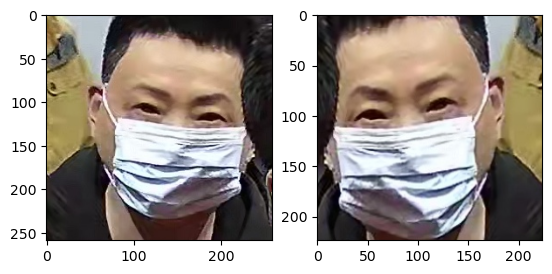

In [19]:
import kornia as K
import cv2
import torch
import matplotlib.pyplot as plt

aug = K.augmentation.AugmentationSequential(
    K.augmentation.RandomHorizontalFlip(p=0.5),
    K.augmentation.RandomResizedCrop((224, 224), scale=(0.64, 1.0))
)
net = torch.nn.Sequential(
    aug,
    torch.nn.Identity(),
)
img = cv2.imread("./phase1/dev/0001/001139.jpg")
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
aug_img = net(img)
plt.subplot(1, 2, 2)
plt.imshow(K.tensor_to_image(aug_img)[:,:,::-1])

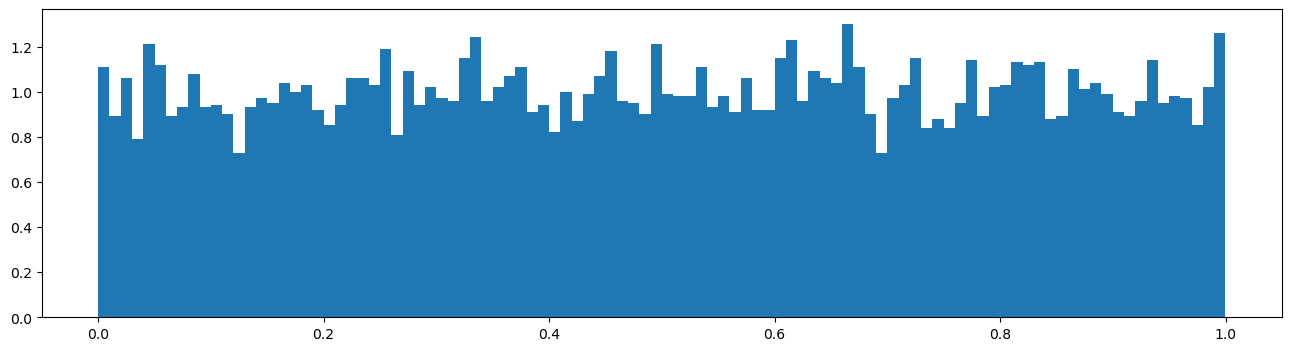

In [6]:
# 绘制 beta(alpha, alpha)的曲线
import numpy as np
import matplotlib.pyplot as plt

# 设置alpha的值
alpha = 1

# 对beta分布进行采样
beta_samples = np.random.beta(alpha, alpha, 10000)

# 绘制采样结果的直方图，绘制图像长宽比为 16:9
plt.rcParams["figure.figsize"] = (16, 4)
plt.hist(beta_samples, bins=100, density=True)
plt.show()